In [1]:
%pylab inline
import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [2]:
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [3]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

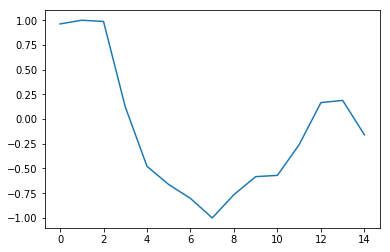

In [4]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt
    

#plot()
plot(makeRandomWalk(15))

[ 1.84004762 -1.23963004]


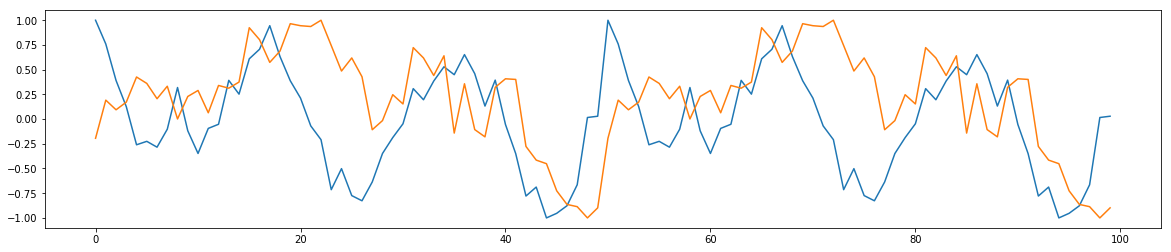

In [5]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
# plot([pJ1b(x,2) for x in arange(100)])

period2 = 2
rawp = np.random.randn(period2)
# rawp = np.array([1.1929,2.6856]);
maxVal = np.max(rawp)
minVal = np.min(rawp)
print(rawp)
rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
# pTri = lambda n,p: ((((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)) * 2 -1
# #pTri = lambda n,p: (n % (p/2))
# plot([pTri(x,10) for x in arange(100)])

patternLength = 50
p_rw1 = makeRandomWalk(patternLength)
p_rw2 = makeRandomWalk(patternLength)
pLoop = lambda n,p: p[n%p.size]
plot([pLoop(x,p_rw1) for x in arange(100)])
plot([pLoop(x,p_rw2) for x in arange(100)])


In [6]:

def makeClassifierNetwork(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    W = Wstar
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Observing pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


#     Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
#                       (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

#     outsRecovered = Wout.dot(allTrainxArgs);
#     NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
#     absSize_readout = mean(mean(abs(Wout), axis=0))
#     print("NRMSE readout: ", NRMSE_readout)
#     print("absSize readout: ", absSize_readout)
    
#     W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
#                       (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
#     NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
#     absSize_W = mean(mean(abs(W), axis=0))
#     print("NRMSE W: ", NRMSE_W)
#     print("absSize W: ", absSize_W)

    return locals()

params = {'N':100, 'NetSR':1.2, 'NetinpScaling':1.3,'BiasScaling':0.6,'TychonovAlpha':0.0001,
         'washoutLength':500, 'learnLength':500, 'TychonovAlphaReadout':0.0001,
          'LR': 0.1,
          'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
#          'patts':np.array([pJ1, pJ2])
         }

net = makeClassifierNetwork(params)


Observing pattern  0
Observing pattern  1


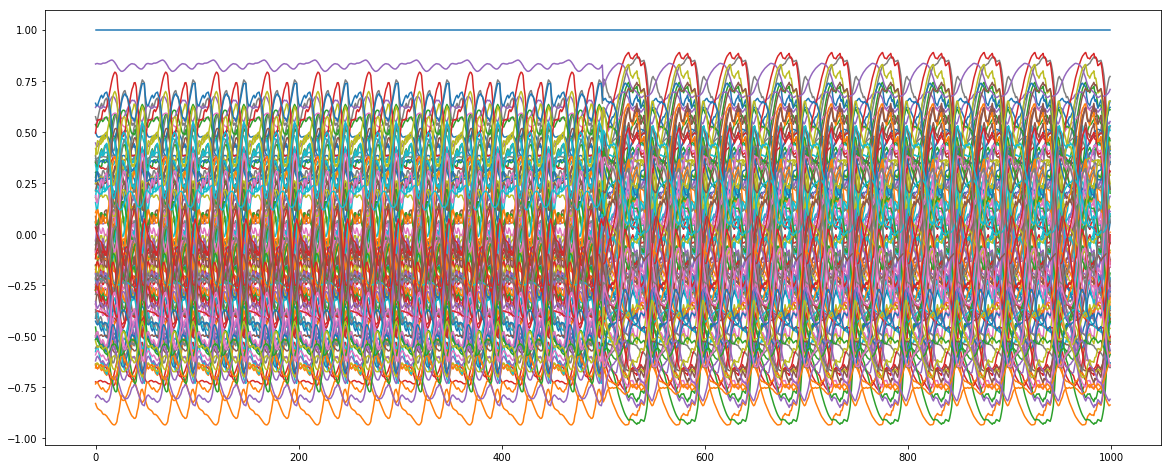

In [7]:
figsize(20,8)
plot(net['allTrainxArgs'].T)

In [8]:
def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()

cnet = computeConceptors(params, net, np.array([10,20.0]))

Computing conceptors, alphas:  [ 10.  20.]


In [9]:
import scipy.spatial.distance as dist


def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((p['patts'].size,recallTestLength))
    pat_CTestPL = np.zeros((1,recallTestLength))
    
    for i_pattern in range(p['patts'].size):
        patt = p['patts'][i_pattern]
        x = np.zeros((p['N'],1))
        for n in range(recallTestLength + p['washoutLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x)) + (cNet['net']['Win'].dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
            if (n > p['washoutLength']):
                pat_CTestPL[0,n-p['washoutLength'] ] = u
                C = cNet['Cs'][0,0]
                C2 = cNet['Cs'][0,1]
                cx = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
                cx_CTestPL[0,n-p['washoutLength']] = cx
                cx2 = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx2 = x.T.dot(C2.dot(x))
                cx_CTestPL[1,n-p['washoutLength']] = cx2

        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        plot(pat_CTestPL.T)
        plot(cx_CTestPL.T)
        classificationScore = np.sum(cx_CTestPL[i_pattern] > cx_CTestPL[1 - i_pattern]) / cx_CTestPL[0].size
        separation = dist.euclidean(cx_CTestPL[i_pattern],cx_CTestPL[1-i_pattern])
        print("Pattern ", str(i_pattern), " classification score: ", classificationScore, ", separation: ", separation)
        #testing

    return locals()


Computing conceptors, alphas:  [ 39.02539259  69.48389026]
Pattern  0  classification score:  0.99 , separation:  12.533072128844715
Pattern  1  classification score:  0.99 , separation:  22.48037114541731
Computing conceptors, alphas:  [ 22.33470699  61.76364898]
Pattern  0  classification score:  0.99 , separation:  12.660164188782733
Pattern  1  classification score:  0.99 , separation:  25.713532299734567
Computing conceptors, alphas:  [ 22.50286658  59.79499607]
Pattern  0  classification score:  0.99 , separation:  12.733559739000512
Pattern  1  classification score:  0.99 , separation:  25.660513423341612
Computing conceptors, alphas:  [ 73.65146784  79.76819367]
Pattern  0  classification score:  0.99 , separation:  12.30079817995502
Pattern  1  classification score:  0.99 , separation:  20.01831946810975
Computing conceptors, alphas:  [  1.84189865  47.78708671]
Pattern  0  classification score:  0.77 , separation:  4.872848584328521
Pattern  1  classification score:  0.99 , s

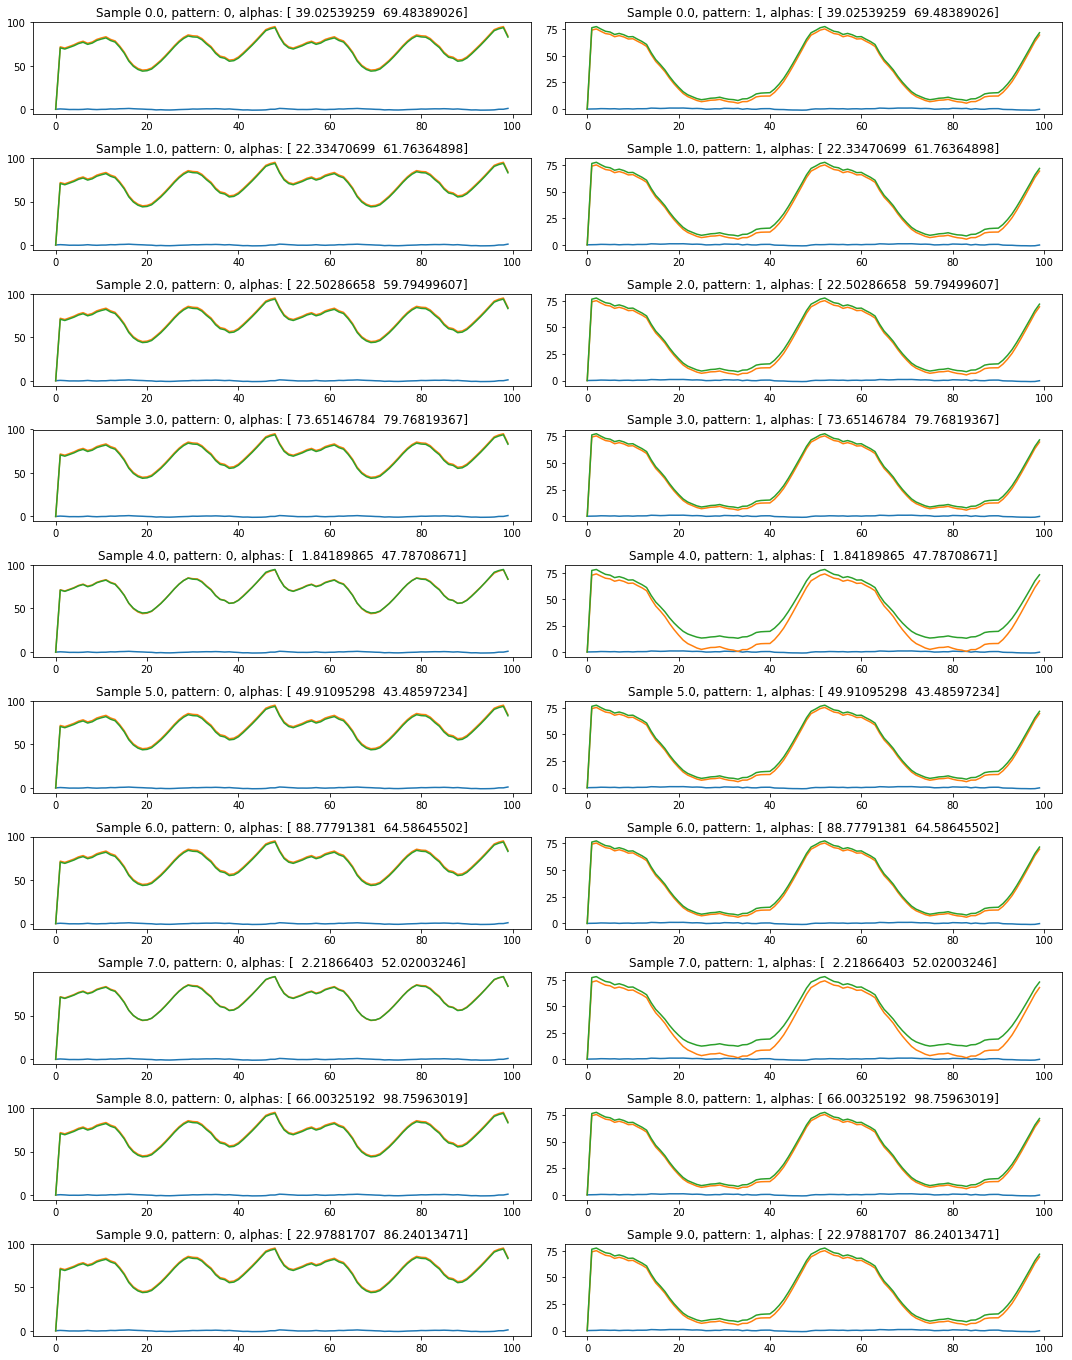

In [10]:
conceptorSampleSize = 10
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.9)
for i_cnet in range(conceptorSampleSize):
    conceptorNets[i_cnet] = computeConceptors(params, net, np.random.random(2) * 100)
    pq = plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


Computing conceptors, alphas:  [ 84.51265671  42.27276532]
Pattern  0  classification score:  0.99 , separation:  0.8921168657134895
Pattern  1  classification score:  0.99 , separation:  0.6925859479266193


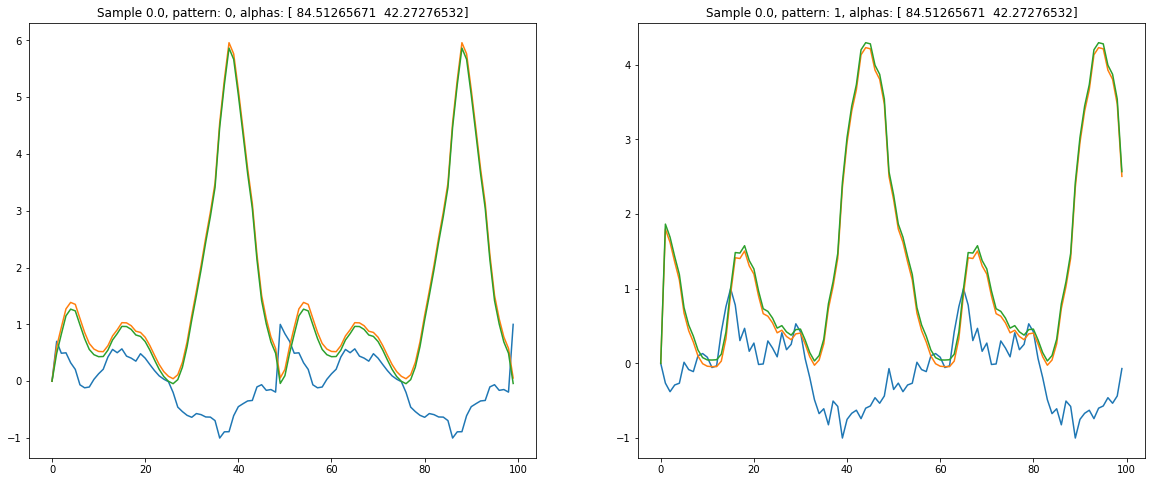

In [532]:
figsize(20,8)
cnet3 = computeConceptors(params, net, np.array([ 84.51265671 , 42.27276532]))
plotConceptorPatterns(params, cnet3, 1, 0, 100)
None

In [486]:
a = np.ones(100) * 30
# a[5] = 0
b = np.ones(100) * 2

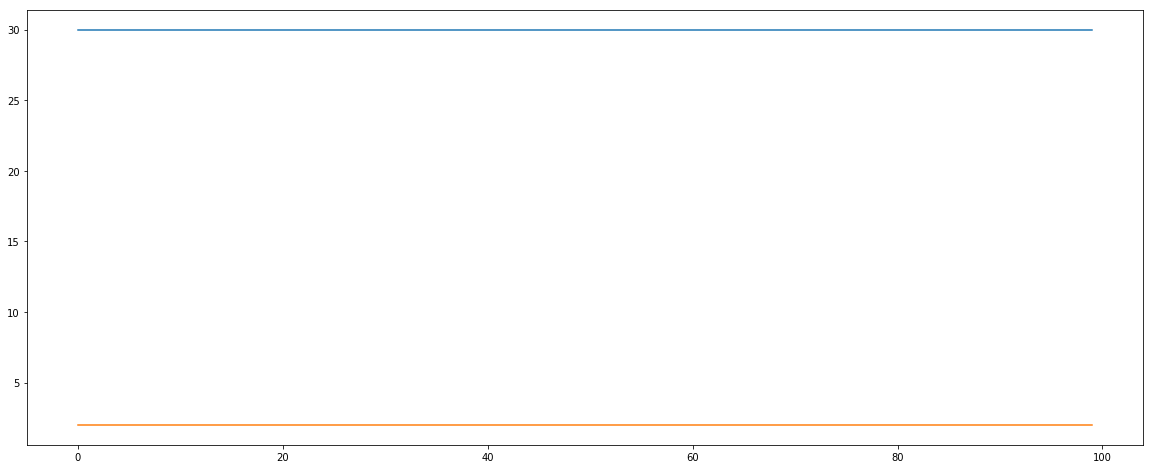

In [487]:
plot(a)
plot(b)

In [488]:
np.sum(a > b) / a.size

1.0

In [489]:
import scipy.spatial.distance as dist
dist.euclidean(a,b)

280.0

0.98999999999999999

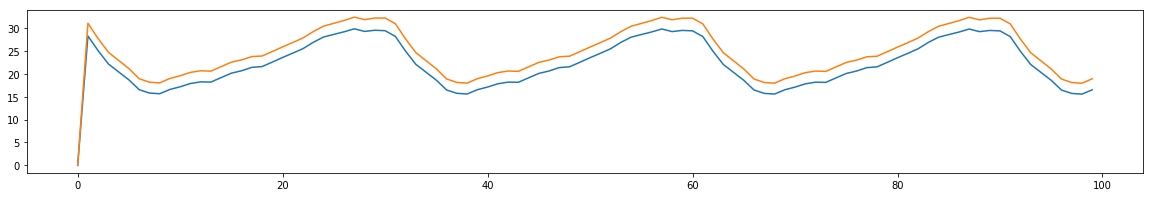

In [506]:
figsize(20,3)
plot(pq['cx_CTestPL'][0])
plot(pq['cx_CTestPL'][1])
np.sum(pq['cx_CTestPL'][1] > pq['cx_CTestPL'][0]) / pq['cx_CTestPL'][1].size

In [12]:
import json

paramsEdit = {key:value for key, value in conceptorNets[0]['p'].items() if key not in ['patts']}
#cnserialised = json.dumps(paramsEdit)
cnserialised = json.dumps(conceptorNets[0]['Cs'])
cnserialised


TypeError: Object of type 'ndarray' is not JSON serializable

In [13]:
import pandas as pd
pd.Series(conceptorNets[0]['Cs'][0,1]).to_json(orient='values')



Exception: Data must be 1-dimensional

In [22]:
import pickle
paramsEdit = {key:value for key, value in conceptorNets[0]['p'].items() if key not in ['patts']}
a = {'conceptors':conceptorNets[0]['Cs'], 'params':paramsEdit}# some NumPy array
serialized = pickle.dumps(a, protocol=0) # protocol 0 is printable ASCII
#deserialized_a = pickle.loads(serialized)
serialized

b'(dp0\nVconceptors\np1\ncnumpy.core.multiarray\n_reconstruct\np2\n(cnumpy\nndarray\np3\n(L0L\ntp4\nc_codecs\nencode\np5\n(Vb\np6\nVlatin1\np7\ntp8\nRp9\ntp10\nRp11\n(L1L\n(L4L\nL2L\ntp12\ncnumpy\ndtype\np13\n(VO8\np14\nL0L\nL1L\ntp15\nRp16\n(L3L\nV|\np17\nNNNL-1L\nL-1L\nL63L\ntp18\nbI00\n(lp19\ng2\n(g3\n(L0L\ntp20\ng9\ntp21\nRp22\n(L1L\n(L100L\nL100L\ntp23\ng13\n(Vf8\np24\nL0L\nL1L\ntp25\nRp26\n(L3L\nV<\np27\nNNNL-1L\nL-1L\nL0L\ntp28\nbI00\ng5\n(V\x83\xa6\x8c\x91\x05r\xa2?\x93I*\xc0m\xf8\x90\xbf\x98\x82\x19\x7f\xeb\x9b\x86\xbfw\x87?\x93\xdb\xba\x9b\xbf\xf3#\xa8v>\xc7u?\\u000a\xdc\xd4\xec\xc5\x8c\x97\xbf\xae\xa0\xd9\xb9\xb6\xb5\x82?\x94\xcf\xc4y\x1e4\x80?a\x81\xcc:\xa5\xc7\x91\xbf\x9e\x1b\x80\xc9\xe3#4\xbf]\xe1S\xc5\x17\x02z?\xf0\xe0%\x8a7\x13\xe9\xbei\xae9\x94>t\x99?\xba\xaf:\x8fQ$\xa2\xbf\xf4\x9b@WL\xd1\x82?\xd0\x9c\x1d\xf8E\xbdC\xbf\xaf8\xaa;\xbbz\x8d\xbf\xfd\xf8z\xc1\xeb\x1a\x8d\xbf\x82\x00\xcep\x81\x1bz\xbf\x05a\x08?S\x9eg\xbfB{\x0fowc\x9c?\xbd\xacw\xafm\xbd\x8e\xbf\xc3\xf3\xcbn\x

In [30]:
netEdit = {key:value for key, value in conceptorNets[0]['net'].items() if key not in ['p']}

serialized = pickle.dumps(netEdit, protocol=0) # protocol 0 is printable ASCII

PicklingError: Can't pickle <function <lambda> at 0x111dbe2f0>: attribute lookup <lambda> on __main__ failed

In [41]:
import dill as pickle
with open(r"/tmp/net.pickle", "wb") as output_file:
    pickle.dump(conceptorNets[0], output_file, protocol=0)

In [36]:
serialised  = pickle.dumps(conceptorNets[0], protocol=0) 

In [38]:
restored = pickle.loads(serialised)

In [39]:
restored['Cs']

array([[ array([[ 0.03602617, -0.01657268, -0.01103958, ...,  0.00813134,
        -0.00686087, -0.00488622],
       [-0.01657268,  0.08915992, -0.04251378, ...,  0.00146289,
         0.05562212, -0.01285524],
       [-0.01103958, -0.04251378,  0.07213097, ..., -0.00704197,
        -0.03332199,  0.01212244],
       ..., 
       [ 0.00813134,  0.00146289, -0.00704197, ...,  0.04112884,
         0.00693727,  0.02928356],
       [-0.00686087,  0.05562212, -0.03332199, ...,  0.00693727,
         0.04078715,  0.00396169],
       [-0.00488622, -0.01285524,  0.01212244, ...,  0.02928356,
         0.00396169,  0.05861386]]),
        array([[ 0.04806226, -0.00787387, -0.00593489, ...,  0.01224473,
         0.00586549, -0.00880008],
       [-0.00787387,  0.09299214, -0.0415282 , ..., -0.00477978,
         0.04702497, -0.02966949],
       [-0.00593489, -0.0415282 ,  0.07590231, ..., -0.0038806 ,
        -0.01970171,  0.00733765],
       ..., 
       [ 0.01224473, -0.00477978, -0.0038806 , ...,  0.